# Duckietown Lane Filter2

up/down arrow keys to move, enter to edit

Esc to exit edit mode

Shift + enter to run code

1/2/3... to add comment

dd to delete cell

press h for more shortcuts

In [3]:
import numpy as np
from scipy.stats import multivariate_normal, entropy
from scipy.ndimage.filters import gaussian_filter
from math import floor, atan2, pi, cos, sin, sqrt
import time
from matplotlib import pyplot as plt
%matplotlib inline

## Environment Setup

In [4]:
# constant
WHITE = 0
YELLOW = 1
RED = 2

lanewidth = 0.4
linewidth_white = 0.04
linewidth_yellow = 0.02


## Generate Vote

### ground projection

(<matplotlib.text.Text at 0x7fbf2496a390>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

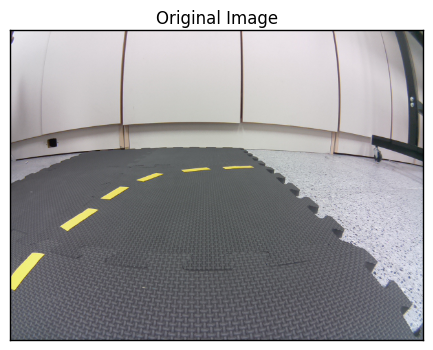

In [5]:
import cv2
img = cv2.imread("images/curve-right.jpg")

dst1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.subplot(111),plt.imshow(dst1,cmap = 'brg')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])


In [6]:
# default homography, you should replace this by your extrinsic
H = np.array(
    [[-4.89775e-05, -0.0002150858, -0.1818273], 
     [0.00099274, 1.202336e-06, -0.3280241],
     [-0.0004281805, -0.007185673, 1]])

In [7]:
# normalized x, y on image plane
img_pt_u = 0.2 # from left
img_pt_v = 0.5 # from top


In [8]:
print H
x_img = np.array([ img_pt_u *640, img_pt_v *480, 1])
print x_img

x_gnd = np.dot(H, x_img)
print x_gnd

x_gnd /= x_gnd[2]
print 'front: ', x_gnd[0]
print 'd\t', x_gnd[1]

[[ -4.89775000e-05  -2.15085800e-04  -1.81827300e-01]
 [  9.92740000e-04   1.20233600e-06  -3.28024100e-01]
 [ -4.28180500e-04  -7.18567300e-03   1.00000000e+00]]
[ 128.  240.    1.]
[-0.23971701 -0.20066482 -0.77936862]
front:  0.307578473931
d	0.257471000475


#### Setup a line segment
* left edge of white lane
* right edge of white lane
* left edge of yellow lane
* right edge of white lane

In [9]:
# right edge of white lane
p1 = np.array([0.4, 0.257])
p2 = np.array([0.3, 0.257])
seg_color = YELLOW


#### compute d_i, phi_i, l_i

In [10]:


t_hat = (p2-p1)/np.linalg.norm(p2-p1)
n_hat = np.array([-t_hat[1],t_hat[0]])
d1 = np.inner(n_hat,p1)
d2 = np.inner(n_hat,p2)
l1 = np.inner(t_hat,p1)
l2 = np.inner(t_hat,p2)

print (d1, d2, l1, l2)

if (l1 < 0):
    l1 = -l1;
if (l2 < 0):
    l2 = -l2;
l_i = (l1+l2)/2
d_i = (d1+d2)/2
phi_i = np.arcsin(t_hat[1])
if seg_color == WHITE: # right lane is white
    if(p1[0] > p2[0]): # right edge of white lane
        d_i = d_i - linewidth_white
        print ('right edge of white lane')
    else: # left edge of white lane
        d_i = - d_i
        phi_i = -phi_i
        print ('left edge of white lane')
    d_i = d_i - lanewidth/2

elif seg_color == YELLOW: # left lane is yellow
    if (p2[0] > p1[0]): # left edge of yellow lane
        d_i = d_i - linewidth_yellow
        phi_i = -phi_i
        print ('right edge of yellow lane')
    else: # right edge of white lane
        d_i = -d_i
        print ('right edge of yellow lane')
    d_i =  lanewidth/2 - d_i

    
print (d_i, phi_i, l_i) 

(-0.25700000000000001, -0.25700000000000001, -0.40000000000000002, -0.29999999999999999)
right edge of yellow lane
(-0.056999999999999995, 0.0, 0.34999999999999998)


### Measurement Likelihood

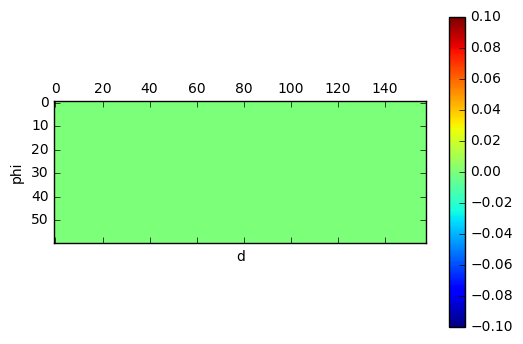

In [11]:
# initialize measurement likelihood

d_min = -0.7
d_max = 0.5
delta_d = 0.02
phi_min = -pi/2
phi_max = pi/2
delta_phi = 0.02
d, phi = np.mgrid[d_min:d_max:delta_d, phi_min:phi_max:delta_phi]

measurement_likelihood = np.zeros(d.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(measurement_likelihood, interpolation='nearest')
fig.colorbar(cax)
plt.ylabel('phi')
plt.xlabel('d')

plt.show()



/home/robotvision/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


(32.0, 78.0)


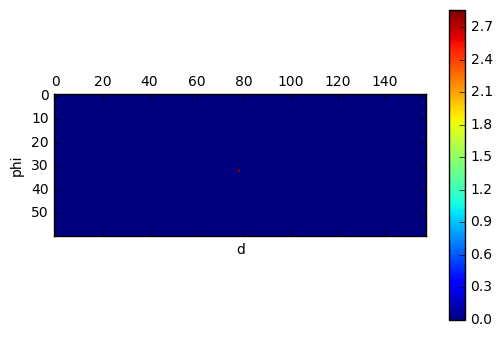

In [12]:
i = floor((d_i - d_min)/delta_d)
j = floor((phi_i - phi_min)/delta_phi)
measurement_likelihood[i,j] = measurement_likelihood[i,j] +  1/(l_i)

print (i, j)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(measurement_likelihood, interpolation='nearest')
fig.colorbar(cax)
plt.ylabel('phi')
plt.xlabel('d')

plt.show()

## Process Model

### 1. Initialize Belief

In [13]:
print d.shape
pos = np.empty(d.shape + (2,))
pos[:,:,0]= d
pos[:,:,1]= phi

print pos.shape

(60, 158)
[[-0.7  -0.7  -0.7  ..., -0.7  -0.7  -0.7 ]
 [-0.68 -0.68 -0.68 ..., -0.68 -0.68 -0.68]
 [-0.66 -0.66 -0.66 ..., -0.66 -0.66 -0.66]
 ..., 
 [ 0.44  0.44  0.44 ...,  0.44  0.44  0.44]
 [ 0.46  0.46  0.46 ...,  0.46  0.46  0.46]
 [ 0.48  0.48  0.48 ...,  0.48  0.48  0.48]]
[[-1.57079633 -1.55079633 -1.53079633 ...,  1.52920367  1.54920367
   1.56920367]
 [-1.57079633 -1.55079633 -1.53079633 ...,  1.52920367  1.54920367
   1.56920367]
 [-1.57079633 -1.55079633 -1.53079633 ...,  1.52920367  1.54920367
   1.56920367]
 ..., 
 [-1.57079633 -1.55079633 -1.53079633 ...,  1.52920367  1.54920367
   1.56920367]
 [-1.57079633 -1.55079633 -1.53079633 ...,  1.52920367  1.54920367
   1.56920367]
 [-1.57079633 -1.55079633 -1.53079633 ...,  1.52920367  1.54920367
   1.56920367]]
(60, 158, 2)


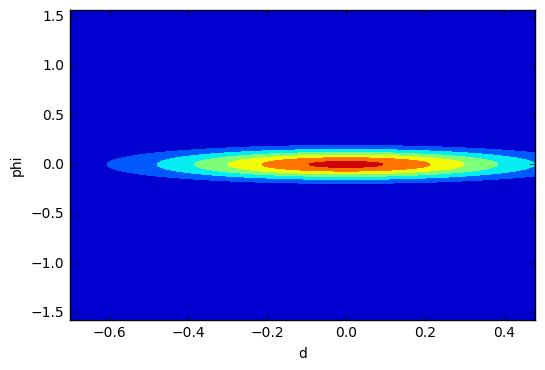

In [20]:
mean_0 = [0, 0]
cov_0 = [[0.1, 0], [0, 0.01]]

RV = multivariate_normal(mean_0, cov_0)
beliefRV=RV.pdf(pos)

plt.ylabel('phi')
plt.xlabel('d')
plt.contourf(d, phi, beliefRV)

### 2.1 Update Belief

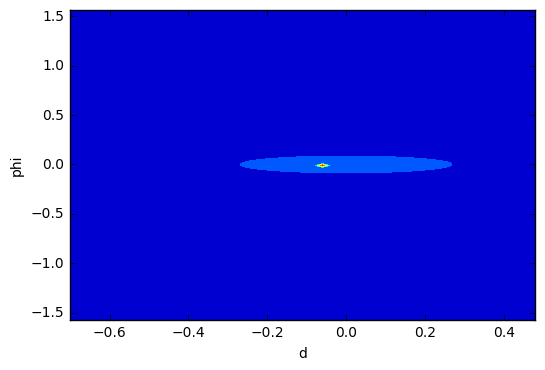

In [13]:
beliefRV=np.multiply(beliefRV+1,measurement_likelihood+1)-1
beliefRV=beliefRV/np.sum(beliefRV)

plt.ylabel('phi')
plt.xlabel('d')
plt.contourf(d, phi, beliefRV)

In [14]:
maxids = np.unravel_index(beliefRV.argmax(),beliefRV.shape)
print maxids
lanePose_d = d_min + maxids[0] * delta_d
lanePose_phi = phi_min + maxids[1] * delta_phi

print lanePose_d
print lanePose_phi

(32, 78)
-0.06
-0.0107963267949
